1. Leitura dos arquivos de dados; 
2. Análise exploratória dos dados (gráfico da série, análise dos dados a nível diário, semanal, mensal, histograma, densidade de probabilidade, características estatísticas, box-plot, médias móveis); 
3. Transformação ou não das séries: trabalhar com a série original e com a transformada. Exemplo: Ln e Box-Cox; 
4. Decomposição da série (Aditivo e Multiplicativo); 
4.Teste Dickey Fuller aumentado, KPSS, PP.

#Leitura dos Dados


In [ ]:
#Importações
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt
  
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Leitura dos arquivos de Dados

SERIE_DAILY = "/content/drive/MyDrive/Modelagem Analítica/daily.csv"
SERIE_HOURLY = "/content/drive/MyDrive/Modelagem Analítica/hourly.csv"

PARSE_DAILY = ['Data Escala de Tempo 1 DM Simp 4', 'Selecione Tipo de DM Simp 4']
PARSE_HOURLY = ['Data Escala de Tempo 1 GE Simp 4', 'Selecione Tipo de GE Simp 4']


def read_data(local_serie, parse_serie):
  serie = pd.read_csv(local_serie, parse_dates=[parse_serie[0]])
  serie = serie[parse_serie]
  serie = serie.rename(columns={parse_serie[0]: 'Data', parse_serie[1]: 'Potencia(MW)'})
  serie.index = serie['Data']
  serie = serie.drop(['Data'], axis=1)
  return serie

#Análise Exploratória dos Dados


**Histograma, densidade de probabilidade, características estatísticas**

In [ ]:
#Função que retorna as características estatísticas a partir de uma série s.
def caracteristicas_estatisticas(s):
  maximo1 = max(s)
  minimo1 = min(s)
  media = s.mean()
  mediana = s.median()
  q1, q2, q3 = s.quantile(q=0.25), s.quantile(q=0.5), s.quantile(q=0.75)
  moda = s.mode()
  amplitude = maximo1 - minimo1
  variancia = s.var()
  desvio_padrao = s.std()
  print('Máximo: ', maximo1, '\n', 'Minímo: ', minimo1, '\n', 'Média: ', media, 
        '\n', 'Mediana: ',mediana, '\n', 'Q1: ', q1, '\n', 'Q2: ', q2,  
        '\n', 'Q3: ', q3, '\n', 'Moda: ', moda[0], '\n', 'Amplitude: ', amplitude, 
        '\n', 'Variância: ', variancia, '\n', 'Desvio Padrão: ', desvio_padrao)

#Função que plota o histograma e a densidade de probabilidades a partir de uma serie
def plot_density_histogram(s):
  sns.distplot(s, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})

Máximo:  13306.963 
 Minímo:  5087.9 
 Média:  9393.276347487363 
 Mediana:  9324.78 
 Q1:  7976.7 
 Q2:  9324.78 
 Q3:  10914.15 
 Moda:  7160.0 
 Amplitude:  8219.063 
 Variância:  3292779.4518329985 
 Desvio Padrão:  1814.6017336685752


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


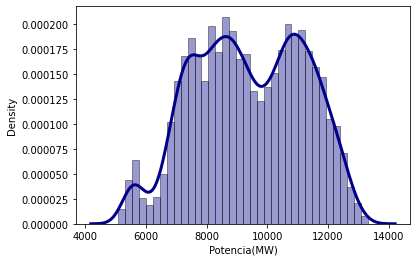

In [ ]:
#Série 1
s = _serie1['Potencia(MW)']

caracteristicas_estatisticas(s)
plot_density_histogram(s)

**Análise dos dados a nível diário, semanal, mensal**

In [ ]:
def plot_resample(serie, periodo='D', metric='sum'):
  if metric == 'sum':
    serie_resample = serie.resample(periodo).sum()
  elif metric == 'mean':
    serie_resample = serie.resample(periodo).mean()
  return serie_resample

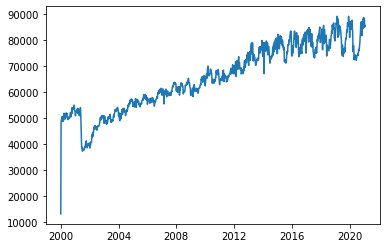

In [ ]:
serie_1_semanal = plot_resample(_serie1, 'W') #Semanal
plt.plot(serie_1_semanal)

**Box-Plot** 

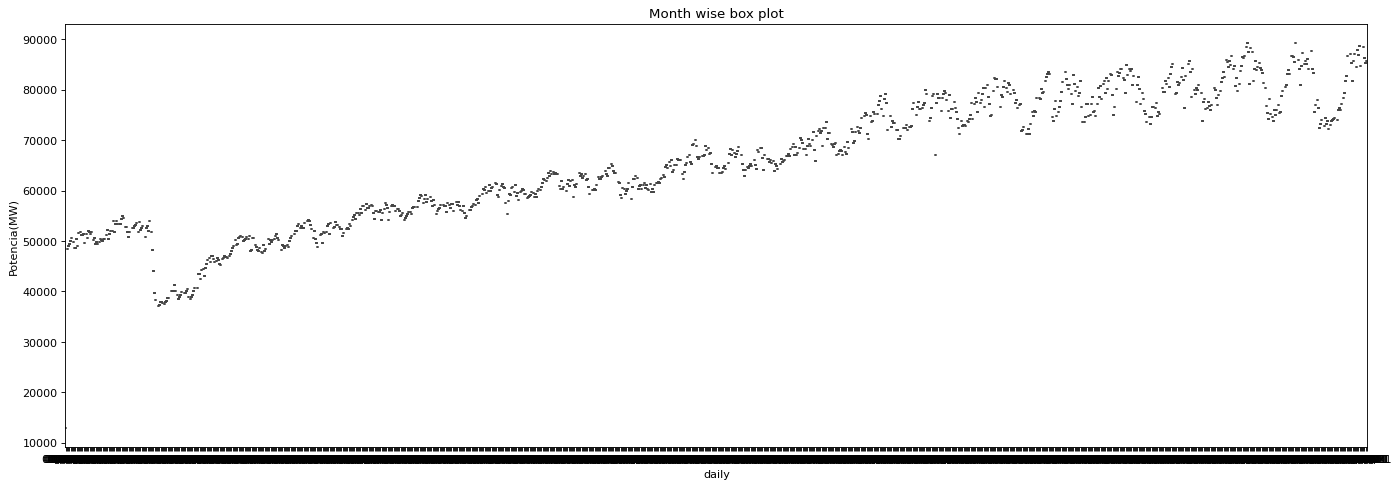

In [ ]:
def box_plot(serie, freq, title):
  # Considerando que a série temporal de entrada tem as datas como index:
  serie_boxplot = serie.copy(deep=True)
  # Prepare data
  if freq == 'year':
    serie_boxplot[freq] = [d.year for d in serie_boxplot.index]
    years = serie_boxplot[freq].unique()
  elif freq == 'month':
    serie_boxplot[freq] = [d.strftime('%b') for d in serie_boxplot.index]
  elif freq == 'weeks':
    print(freq)
    serie_boxplot[freq] = [d.strftime('%W') for d in serie_boxplot.index]
  elif freq == 'daily':
    serie_boxplot[freq] = [d.strftime('%D') for d in serie_boxplot.index]  

  # Draw Plot
  
  figure = plt.figure(figsize=(21,7), dpi= 80)
  sns.boxplot(x=freq, y='Potencia(MW)', data=serie_boxplot)
  # Set Title
  plt.title(title)

  plt.show()

# box_plot(serie_1_semanal, 'daily', 'Month wise box plot')


#**Médias Móveis**

Referências

https://towardsdatascience.com/moving-averages-in-python-16170e20f6c

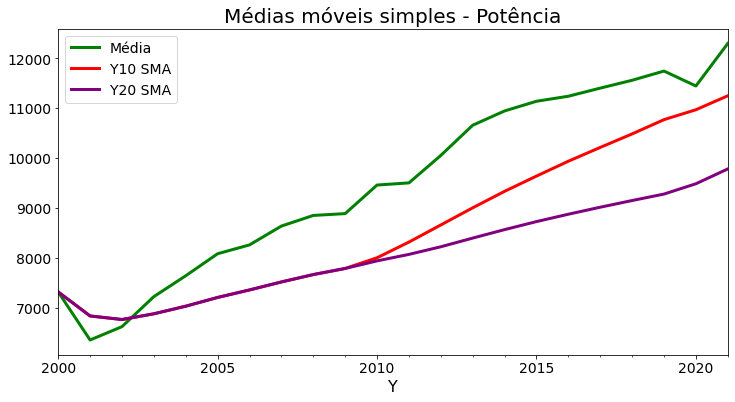

In [ ]:
# simple moving average (SMA)
def moving_avg(serie, janela1, janela2, freq):
  serie_moving_avg = serie.copy(deep=True)
  serie_moving_avg = plot_resample(serie_moving_avg, periodo=freq, metric='mean')
  moving_avg_col = freq + (janela1)
  serie_moving_avg[moving_avg_col] = 0
  serie_moving_avg[moving_avg_col] = serie_moving_avg['Potencia(MW)'].rolling(int(janela1), min_periods=1).mean()
  moving_avg_col = freq + (janela2)
  serie_moving_avg[moving_avg_col] = serie_moving_avg['Potencia(MW)'].rolling(int(janela2), min_periods=1).mean()

  # colors for the line plot
  colors = ['green', 'red', 'purple']

  # line plot - the yearly average air temperature in Barcelona
  serie_moving_avg.plot(color=colors, linewidth=3, figsize=(12,6))

  # modify ticks size
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.legend(labels =['Média', freq + (janela1) + ' SMA', freq + (janela2)+ ' SMA'], fontsize=14)

  # title and labels
  plt.title('Médias móveis simples - Potência', fontsize=20)
  plt.xlabel(freq, fontsize=16)


moving_avg(_serie1, '10', '20', 'Y')

#Transformação das séries: Box Cox e Ln

**Box Cox**

Lambda value used for Transformation: 1.0952244035436294


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


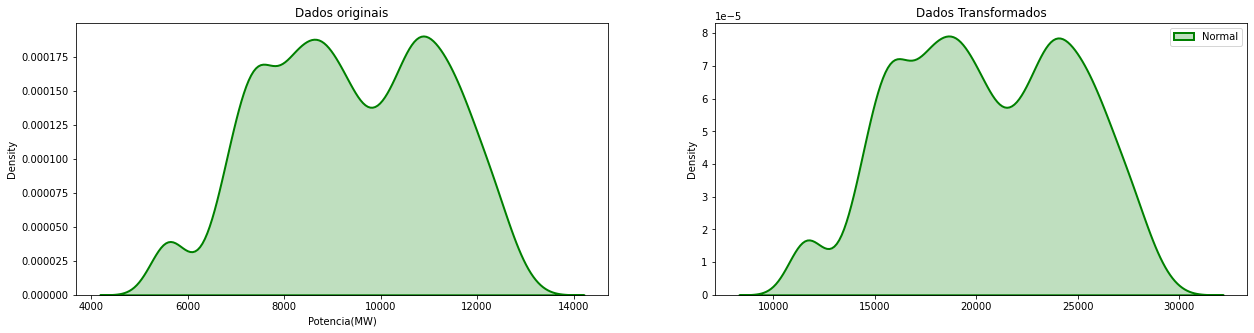

In [ ]:
def boxplot_transf(serie):
  serie_boxplot = serie.copy(deep=True)
  original_data = serie1_boxplot['Potencia(MW)']  
  fitted_data, fitted_lambda = stats.boxcox(original_data) 
  
  fig, ax = plt.subplots(1, 2) 
  
  #plota os dados originais
  sns.distplot(original_data, hist = False, kde = True, 
              kde_kws = {'shade': True, 'linewidth': 2},  
              label = "Non-Normal", color ="green", ax = ax[0]) 
  ax[0].set_title('Dados originais', fontsize=12)
  sns.distplot(fitted_data, hist = False, kde = True, 
              kde_kws = {'shade': True, 'linewidth': 2},  
              label = "Normal", color ="green", ax = ax[1])
  ax[1].set_title('Dados Transformados', fontsize=12)

    
  # adding legends to the subplots 
  plt.legend(loc = "upper right") 
    
  # rescaling the subplots 
  fig.set_figheight(5) 
  fig.set_figwidth(21)
print(f"Lambda da transformação: {fitted_lambda}")

boxplot_transf(_serie1)

**Ln**


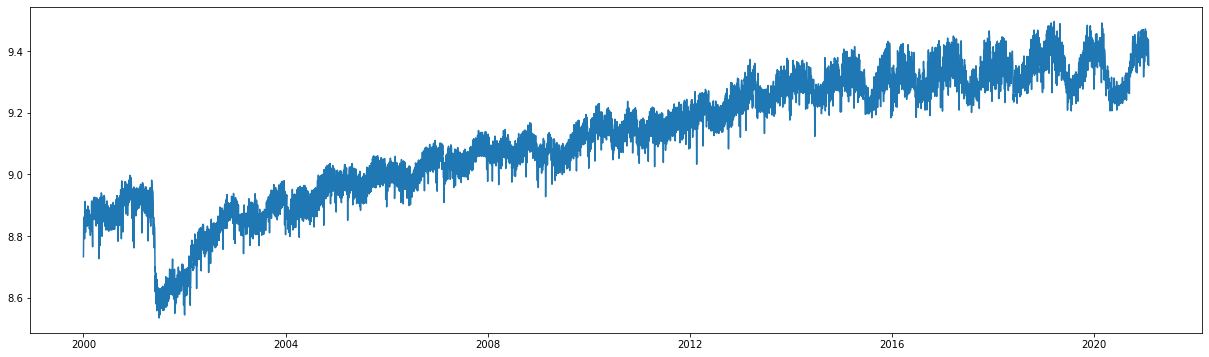

In [ ]:
def ln_transformation(serie):
  ts_log = np.log(serie)
  ts_log.head()
  plt.plot(ts_log)
ln_transformation(_serie1)

#Decomposição da série (Aditivo e Multiplicativo)


In [ ]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 21, 6

def decompose(serie, _model):
  result = seasonal_decompose(serie, model=_model)
  result.plot()

#Teste Dickey Fuller aumentado, KPSS, PP.

In [ ]:
#Teste Dickey Fuller aumentado, KPSS, PP.

from statsmodels.tsa.stattools import adfuller, kpss
def adf_test(serie):
  result = adfuller(serie['Potencia(MW)'].values, autolag='AIC')
  print(f'ADF Statistic: {result[0]}')
  print(f'p-value: {result[1]}')
  for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

def kpss_test(serie):
# KPSS Test
  result = kpss(serie['Potencia(MW)'].values, regression='c')
  print('\nKPSS Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  for key, value in result[3].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

#Modelo de Persistência

In [ ]:
def persistence_model(serie):
  train = _serie1.sample(frac=0.75)
  test = _serie1.sample(frac=0.25)
  # Prepare data
  test = test['Potencia(MW)'].values
  train = [x for x in train.values]

  # Walk-forward validation
  predictions = list()
  for i in range(len(test)):
    yhat = train[-1]

    # Store forecast in list of predictions
    predictions.append(yhat)

    # Add actual observation to train for the next loop
    obs = test[i]
    train.append(obs)
    # print('>Predicted=%.3f, Expected=%.3f' % (float(yhat), float(obs)))
  # Report performance
  rmse = sqrt(mean_squared_error(test, predictions))
  print('RMSE: %.3f' % rmse)
  # Plot predicted vs expected values
  plt.plot(test, color='blue')
  # plt.plot(predictions, color='red')
  plt.show()

# Série 1 - Dados diários

In [ ]:
#Leitura dos Dados

serie_diaria = read_data(SERIE_DAILY, PARSE_DAILY)
_serie1 = serie_diaria

In [ ]:
#Gráfico da série diária

plt.plot(_serie1)

In [ ]:
serie_1_semanal = plot_resample(_serie1, 'W') #Semanal
decompose(serie_1_semanal, 'multiplicative')

# Série 2 - Dados por Hora